#### Tools For Modern Macroeconometrics

## Term paper - 1st stage

##### Summer semester 2022/23

*Authors:* Petr Čala, Tomáš Bajcár
___
### *Environment preparation, package handling, and file validation:*

In [18]:
##### ENVIRONMENT PREPARATION #####

# Clean the environment
rm(list = ls()) 

#Plot display options
options(warn=-1, repr.plot.width = 12, repr.plot.height = 6, xts.warn_dplyr_breaks_lag=FALSE, scipen=999)

set.seed(420)

##### STATIC #####

# Required packages
packages <- c(
  "pdfetch", # Downloading data
  "forecast", # autoplot function, ARIMA
  "xts", # plot.xts function
  "urca", # Unit root test
  "seasonal", # Seasonal adjustments
  "stats", # Autocorr fun, spectrum, periodogram
  "mFilter", # HP filter
  "neverhpfilter", # Hamilton's regression filter
  "tsbox",
  "strucchange", # Structural breaks in data
  "quantmod", # Period-over-period changes ("periodReturn")
  "TSA", # periodogram
  "statcheck", # Structural breaks
  "tseries" # Tests
)
# Other useful packages - "dplyr", "quantmod", "moments", "StableEstim", "stabledist", "tseries")

##### PREPARATION #####

# Load the source script
if (!file.exists("cala_termpaper_source.R")){
  print('Please make sure to put the source file \"cala_termpaper_source\" in
        your working directory.')
  stop("Source file failed to load.")
} else{
  source("cala_termpaper_source.R")
  print("Source file loaded.")
}

# Load packages
loadPackages(packages)


[1] "Source file loaded."
[1] "All packages loaded successfully"


### *Obtaining the data*:

We fetch the data using the *fetch* function form the `pdfetch` package. We will use the widest range of time possible, and with this, fetch the data for GDP and Consumer Price Index.

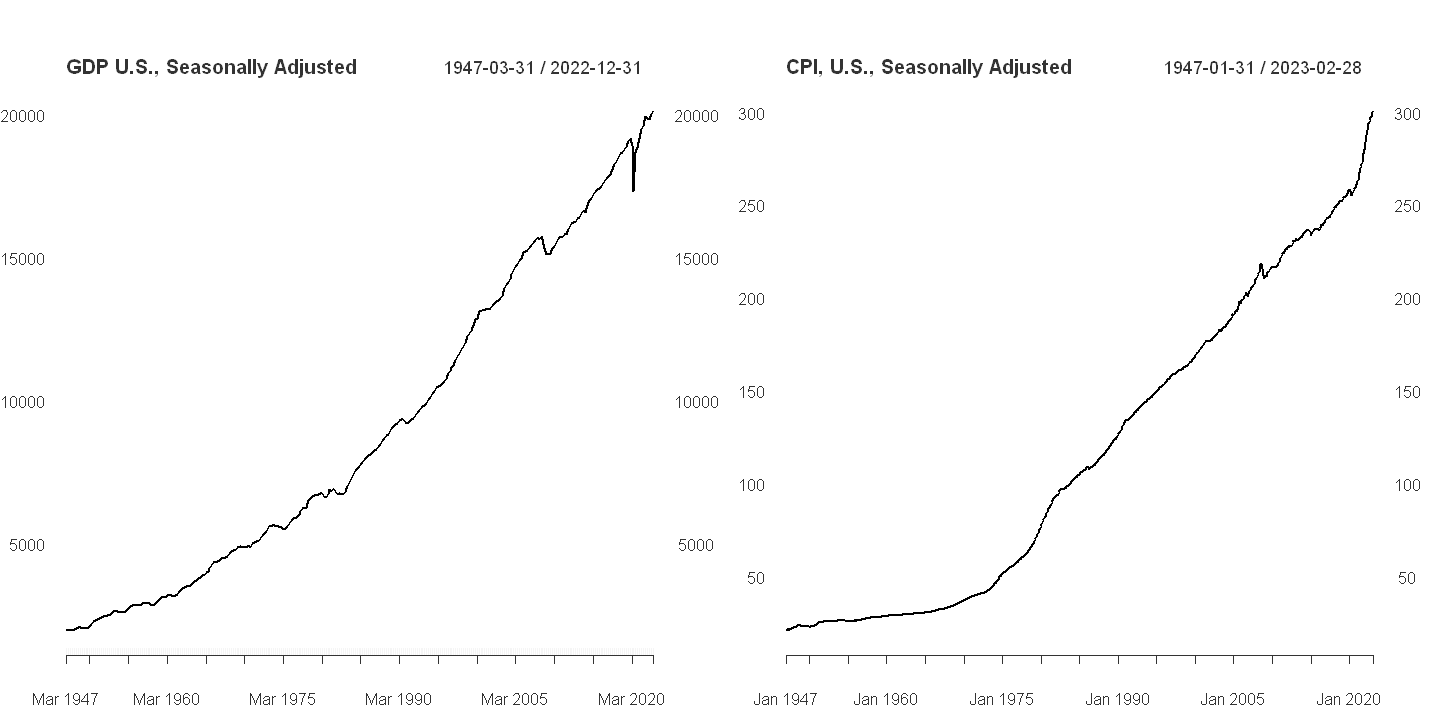

In [19]:
# Set the static variables
us_gdp_id <- "GDPC1" # https://fred.stlouisfed.org/series/GDPC1
us_cpi_id <- "CPIAUCSL" # https://fred.stlouisfed.org/series/CPIAUCSL

# Retrieve the U.S. GDP and consumer price index data using "pdfetch_FRED"
us_gdp_data <- pdfetch_FRED(us_gdp_id)
us_cpi_data <- pdfetch_FRED(us_cpi_id)

# Plot the original time series using 'plot.xts'
par(mfrow=c(1,2))
plot.xts(us_gdp_data, main="GDP U.S., Seasonally Adjusted", grid.col=NA, yaxis.left=TRUE)
plot.xts(us_cpi_data, main="CPI, U.S., Seasonally Adjusted", grid.col=NA, yaxis.left=TRUE)


### *Data transformation*:

Both series were available in the seasonally adjusted form, so we could skip step two. In case they were not, however, we appended a `handleSeasonality` function, which would extract the respective components out of the series. This function can be found in our source code, but we will not be using it.

For now, we will just transform the series to logs, as instructed.

[1] "Transforming the series to log..."


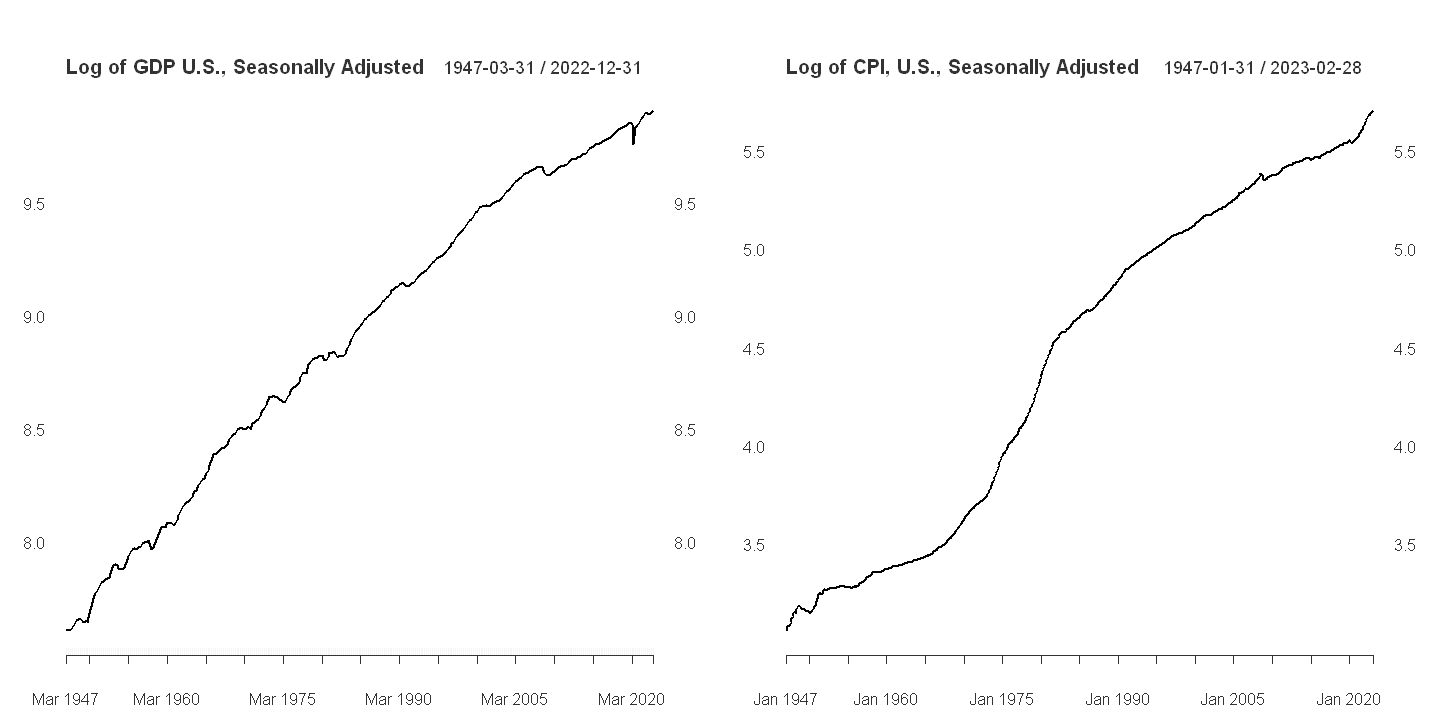

In [20]:
### 1.
print('Transforming the series to log...')
gdp_log <- log(us_gdp_data)
cpi_log <- log(us_cpi_data)

# Plot the new time series using 'plot.xts'
par(mfrow=c(1,2))
plot.xts(gdp_log, main="Log of GDP U.S., Seasonally Adjusted", grid.col=NA, yaxis.left=TRUE)
plot.xts(cpi_log, main="Log of CPI, U.S., Seasonally Adjusted", grid.col=NA, yaxis.left=TRUE)
### 2.
# gdp_quarterly <- handleSeasonality(gdp_log, "GDP")
# cpi_log <- handleSeasonality(cpi_log, "CPI")

We can **check the data for stationarity, structural breaks, and order of integration**, using a custom function - `runStructuralChecks`.

In [21]:
# Run various structural checks using a compact function (for details see the source R script)
par(mfrow=c(2,2))
runStructuralChecks(gdp_log, "quarterly GDP", print_plots=F)
runStructuralChecks(cpi_log, "monthly CPI", print_plots=F)

[1] "Running structural checks for quarterly GDP"
[1] "Testing for breakpoints..."


Extracting statistics...



  |======================================================================| 100%
statcheck did not find any results
[1] "Running the augmented Dickey-Fuller test for quarterly GDP..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -1.197, Lag order = 1, p-value = 0.9057
alternative hypothesis: stationary

[1] "The transformed series is integrated of order 1"
[1] "Running structural checks for monthly CPI"
[1] "Testing for breakpoints..."


Extracting statistics...



  |======================================================================| 100%
statcheck did not find any results
[1] "Running the augmented Dickey-Fuller test for monthly CPI..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -0.21648, Lag order = 1, p-value = 0.99
alternative hypothesis: stationary

[1] "The transformed series is integrated of order 1"


These checks suggest both series are integrated of order one, so **taking the percentage changes could make them stationary**. As for structural breaks with these original series, the tests for breakpoints do not seem to find anything, which could leave us thinking that **there are no major structural breaks** in the source data.

After extracting the seasonal components from the CPI, we can take a look at the Y-O-Y, M-O-M, and P-O-P changes. For GDP, we can not do the M-O-M, because we do not have the data. With CPI, there arise several missing values when computing the percentage change, so we simply remove these, for simplicity. Otherwise, we make good use of a custom function, which allows us to directly compute the percentage changes, while defining the number of periods to look back during the computation.

[1] "Transforming data..."
[1] "Data transformation to percentage changes complete."


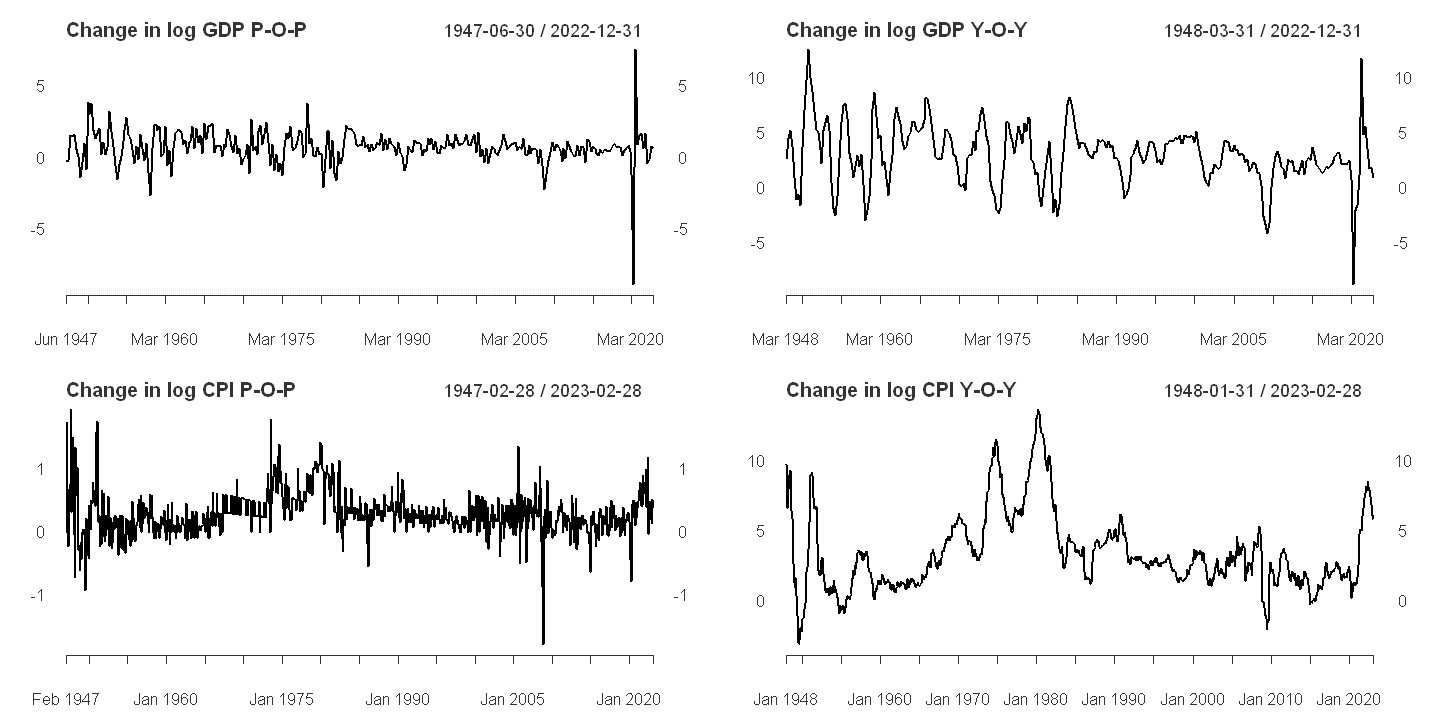

In [23]:
### 3. 
print('Transforming data...')

## Period-over-period percentage changes
gdp_pop_change <- na.omit(100*diff(gdp_log, 1))
cpi_pop_change <- na.omit(100*diff(cpi_log, 1))

# ## Calculate month-to-month changes
# Redundant - impossible for GDP due to lack of data, and already in that form for cpi

# ## Year-over-year percentage changes
gdp_yoy_change <- na.omit(100*diff(gdp_log, 4))
cpi_yoy_change <- na.omit(100*diff(cpi_log, 12))


print('Data transformation to percentage changes complete.')

par(mfrow=c(2,2))
plot.xts(gdp_pop_change, main="Change in log GDP P-O-P", grid.col=NA, yaxis.left=TRUE)
plot.xts(gdp_yoy_change, main="Change in log GDP Y-O-Y", grid.col=NA, yaxis.left=TRUE)
plot.xts(cpi_pop_change, main="Change in log CPI P-O-P", grid.col=NA, yaxis.left=TRUE)
plot.xts(cpi_yoy_change, main="Change in log CPI Y-O-Y", grid.col=NA, yaxis.left=TRUE)

### *Structural validation of the transformed series*:

With these data, we can take a look at any potential remaining seasonal effects in the m-o-m series of CPI, and p-o-p series of GDP (because there are no monthly GDP data available). Then we check for structural breaks, stationarity, and other characteristics.

[1] "Running structural checks for quarterly GDP"
[1] "Testing for breakpoints..."


Extracting statistics...



  |======================================================================| 100%
statcheck did not find any results
[1] "Running the augmented Dickey-Fuller test for quarterly GDP..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -10.579, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary

[1] "The transformed series is stationary and has zero order of integration"
[1] "Running structural checks for monthly CPI"
[1] "Testing for breakpoints..."


Extracting statistics...



  |======================================================================| 100%
statcheck did not find any results
[1] "Running the augmented Dickey-Fuller test for monthly CPI..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -12.568, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary

[1] "The transformed series is stationary and has zero order of integration"


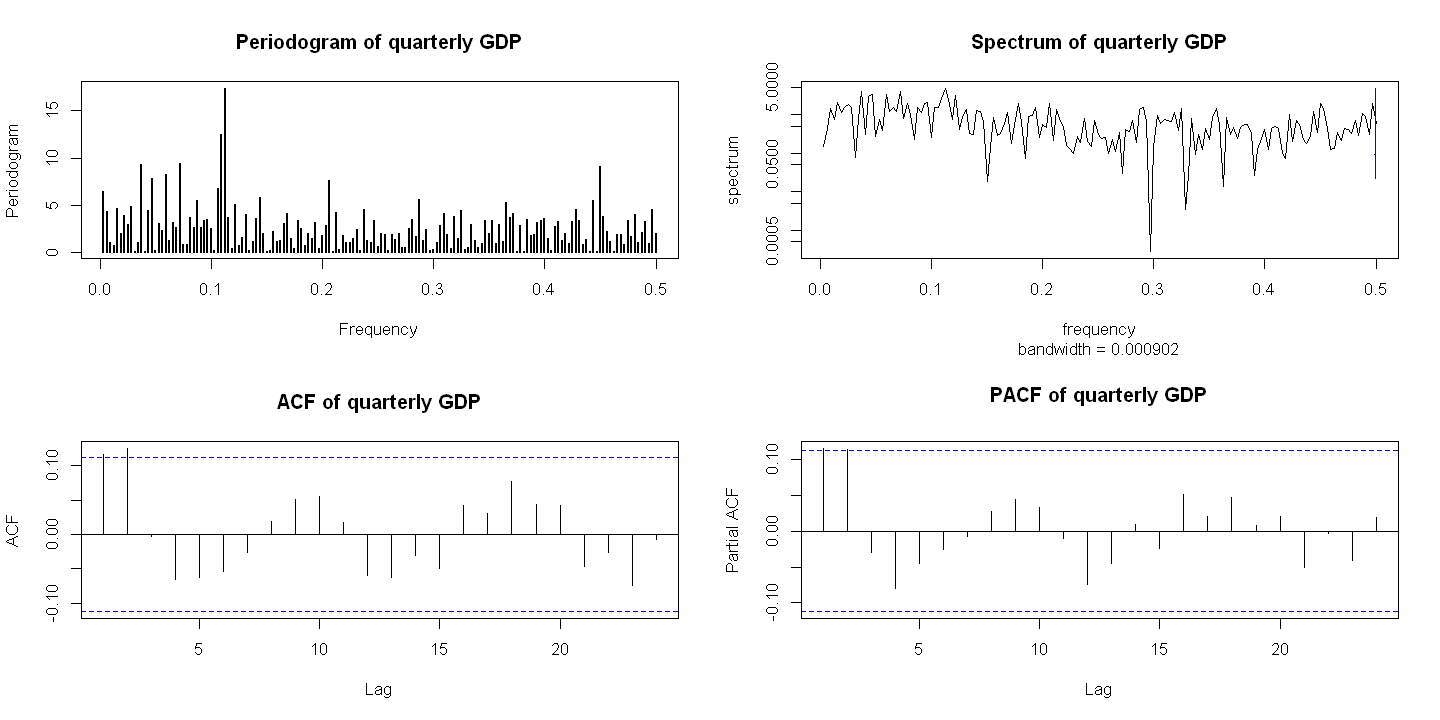

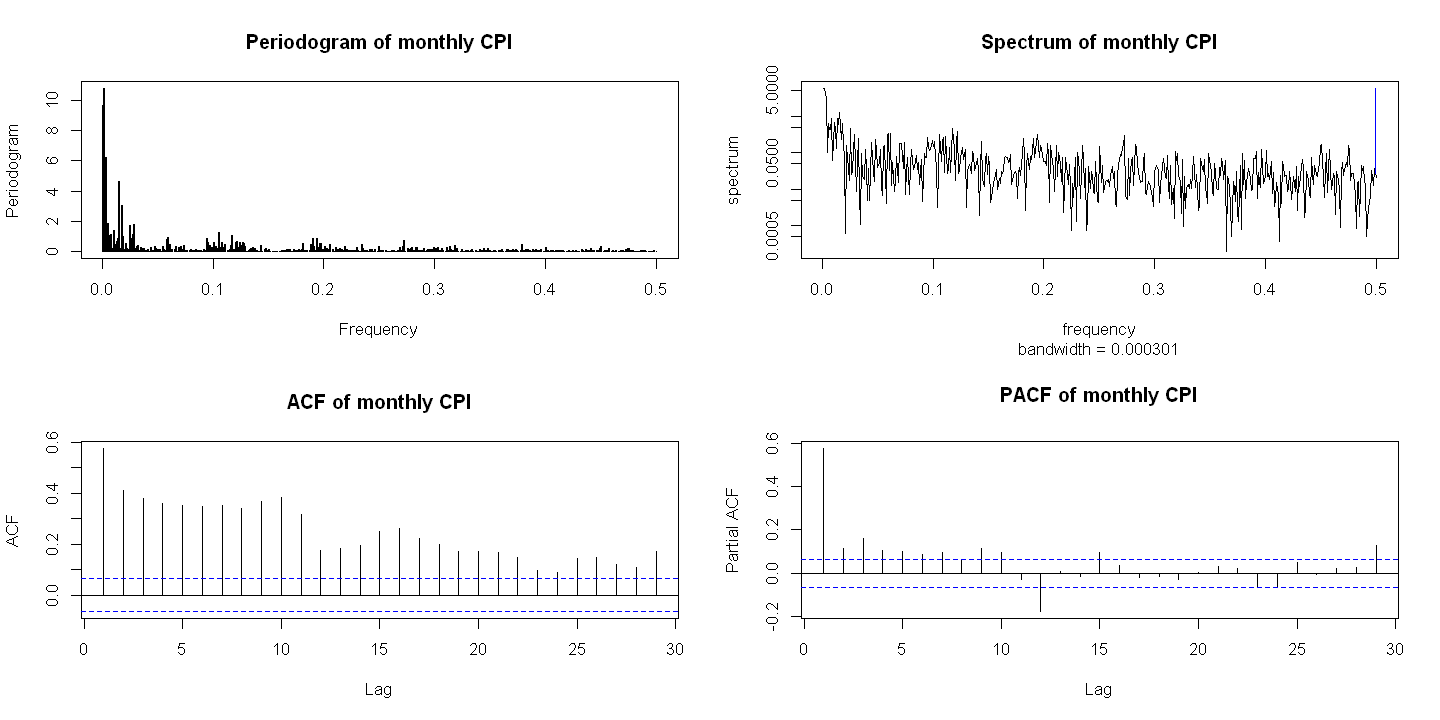

In [24]:
# Run various structural checks using a compact function (for details see the source R script)
par(mfrow=c(2,2))
runStructuralChecks(gdp_pop_change, "quarterly GDP")
runStructuralChecks(cpi_pop_change, "monthly CPI")

Both Dickey-Fuller tests suggest stationarity quite strongly, which is the expected outcome. It is good that no double differencing appears to be needed in our case.

Looking at the periodogram of both series, we can spot **no apparent seasonality**. Any repeating patterns emerge in clusters, and not in stand-alone spikes, which is what would happen if strong seasonality was present in the data. 

With both series, higher frequencies are very slightly more common, but certainly not enough to claim that any of the two series is defined only by a limited spectrum of frequencies; far from it.

As for the structural breaks tests, no obvious breakpoints were detected, so we can assume structural integrity.

### *Linear Model Estimation*:

In this section, we will try to estimate several linear models, to see which fit the two series the best. Both of the series should be stationary, so linear models should work just fine in our case. We will model on the monthly data, which allow for the largest granularity. We will run the specification check models on data of other granularity at the end.

The ACF and PACF plots for either series suggest a simple model should suffice, say *ARMA(2,0)* in the case of GDP, and *ARMA(1,0)* in the case of CPI. We will first see what model the `auto.arima` function suggests, to get an idea, and then go on to



In [25]:
auto.arima(gdp_pop_change)
auto.arima(cpi_pop_change)

Series: gdp_pop_change 
ARIMA(3,1,2) 

Coefficients:
         ar1     ar2      ar3      ma1     ma2
      0.9038  0.0343  -0.1485  -1.7976  0.8012
s.e.  0.1635  0.0787   0.0573   0.1562  0.1551

sigma^2 = 1.293:  log likelihood = -466.53
AIC=945.05   AICc=945.34   BIC=967.32

Series: cpi_pop_change 
ARIMA(4,1,1) 

Coefficients:
         ar1      ar2     ar3      ar4      ma1
      0.3116  -0.0597  0.0145  -0.0220  -0.8653
s.e.  0.0685   0.0477  0.0467   0.0498   0.0605

sigma^2 = 0.07365:  log likelihood = -102.62
AIC=217.23   AICc=217.33   BIC=246.13

`auto.arima` suggest *ARIMA(3,1,2)* for the GPD, and *ARIMA(4,1,1)* for CPI. We suppose that the integration of order 1 suggested for both series may arise from the variability in frequencies of the data, but otherwise the data appears stationary, so we do not think it necessary to include the integration order.

To get an idea of which orders might be good to model, we resort to an iterative function `getBoxLjung`, which will create 36 basic ARIMA models, and return the values of their Ljung-Box test, ran on their residuals, understandably. We will then search for a **tradeoff between the number of orders and the large p-value from the test**, as the simpler models are usually the best.

In [13]:
# Get the data frame of p-values from the B-L test
print('Monthly GDP Ljung-Box test p-values for different orders of ARIMA')
getBoxLjung(gdp_pop_change)

print('Monthly CPI Ljung-Box test p-values for different orders of ARIMA')
getBoxLjung(cpi_pop_change)

[1] "Monthly GDP Ljung-Box test p-values for different orders of ARIMA"


AR order,MA order,1 lag,2 lags,3 lags
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.7315598,0.3781150,0.5422582
1,2,0.9947044,0.9931412,0.9995545
1,3,0.9791477,0.9943404,0.9931208
1,4,0.9904586,0.9994027,0.9999888
1,5,0.9988252,0.9999010,0.9999979
2,1,0.9893022,0.9854172,0.9985928
2,2,0.7700814,0.3940103,0.5979244
2,3,0.9419604,0.4322455,0.5215765
2,4,0.9961277,0.9991159,0.9911170


[1] "Monthly CPI Ljung-Box test p-values for different orders of ARIMA"


AR order,MA order,1 lag,2 lags,3 lags
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.001619066,0.00000315445,0.000000596885
1,2,0.904090190,0.98178540805,0.949642451542
1,3,0.973563609,0.99317451180,0.991068762422
1,4,0.971992581,0.99484508160,0.994209833693
1,5,0.941155831,0.99663021799,0.999755417898
2,1,0.614084733,0.23719867994,0.410841393040
2,2,0.970015527,0.99475445952,0.988878965580
2,3,0.835507488,0.90624883644,0.717776631218
2,4,0.985883321,0.97808475905,0.939263436228


For GDP, a solid candidate seems to be the *ARMA(1,2)* model, where the residuals perform the best in the Ljung-Box test among models with low order of integration, the model range in which we would ideally like to search. Just as a reminder, we are testing for the autocorrelation of residuals after constructing the model, where the alternative is serial correlation, so high L-B statistic means less likely presence of correlation, which is good. 

So we ran the (1,2) model, but, but found that no coefficients were statistically significant, so maybe autotocorrelation is not the only thing that matters. We were then thinking about the suggested *ARIMA(3,1,2)* model, but the fact that `auto.arima` suggests orders of integration in spite of strong Ljung-Box stationarity hypothesis support, makes us think there might be something inherently incorrect with the function's behavior. We thus chose a close alternative in the ***ARIMA(3,0,1)***, which is what we end up with for GDP.

When it comes to CPI, there was one big concern. No matter the model, we could not get rid of autocorrelation in higher lags of the series, notably around lag 12, which can be seen in both correlation functions below. This would suggest yearly trends in the data, but when we re-checked the seasonality using our `handleSeasonality` function, we got the same results, which only validated that our function is well written, and that **we indeed have seasonally adjusted data from the source**. We decided to not look too deep into this, and proceeded with the modelling as per usual, which led us to the model ***ARIMA(1,0,2)***, the one that showed the best result in the two aforementioned criteria.

Results of the modelling can be seen below.


Call:
arima(x = gdp_pop_change, order = c(3, 0, 1))

Coefficients:
         ar1     ar2      ar3      ma1  intercept
      0.7832  0.0504  -0.1339  -0.6777     0.7571
s.e.  0.2892  0.0790   0.0581   0.2880     0.0695

sigma^2 estimated as 1.269:  log likelihood = -466.04,  aic = 942.08


	Box-Ljung test

data:  GDP_ARMA$residuals
X-squared = 0.010735, df = 1, p-value = 0.9175



	Box-Ljung test

data:  GDP_ARMA$residuals
X-squared = 0.011241, df = 2, p-value = 0.9944



	Box-Ljung test

data:  GDP_ARMA$residuals
X-squared = 0.40521, df = 3, p-value = 0.9392


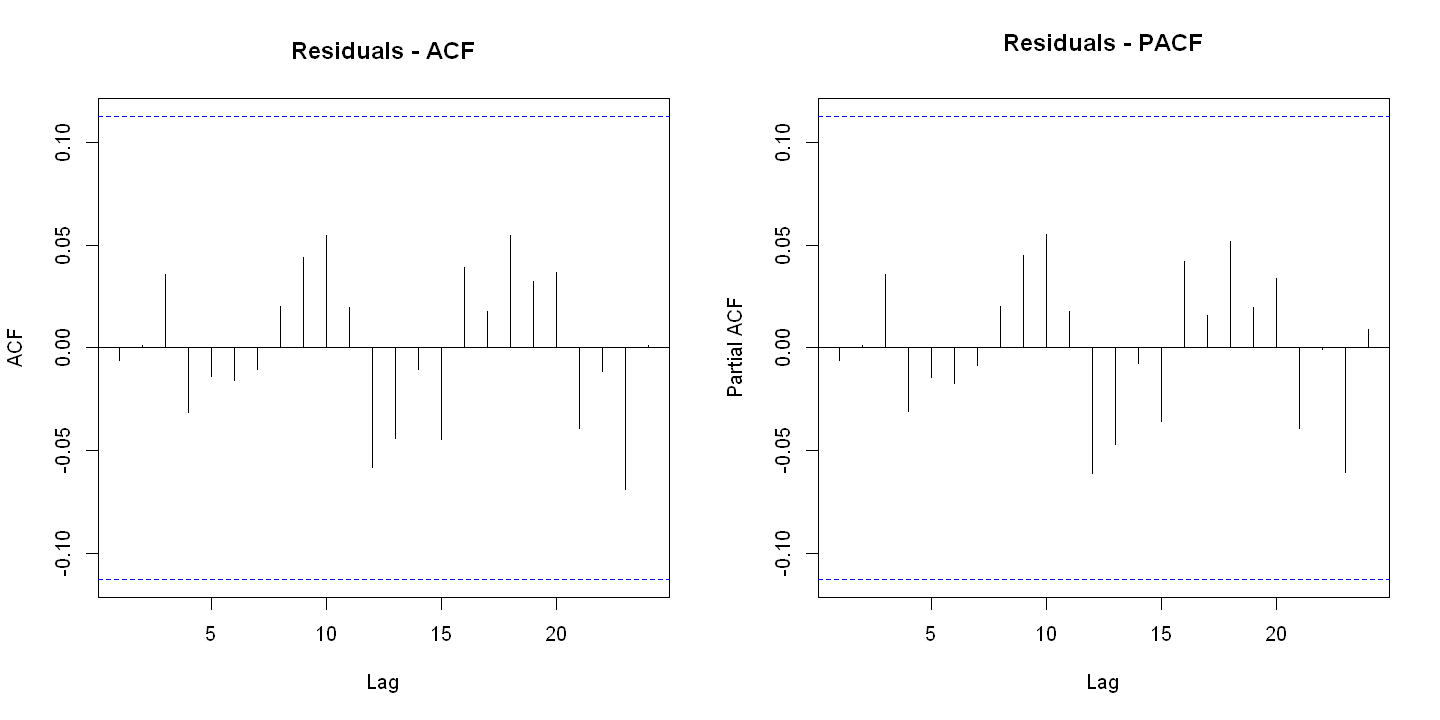

In [29]:
### 4.

## GDP ARMA modelling
GDP_ARMA <- arima(gdp_pop_change, order = c(3, 0, 1))
GDP_ARMA

par(mfrow = c(1, 2))
acf(GDP_ARMA$residuals, main = 'Residuals - ACF')
pacf(GDP_ARMA$residuals, main = 'Residuals - PACF')

Box.test(GDP_ARMA$residuals, type = "Ljung-Box", lag = 1)
Box.test(GDP_ARMA$residuals, type = "Ljung-Box", lag = 2)
Box.test(GDP_ARMA$residuals, type = "Ljung-Box", lag = 3)


Call:
arima(x = cpi_pop_change, order = c(1, 0, 2))

Coefficients:
         ar1      ma1      ma2  intercept
      0.9621  -0.5324  -0.2304     0.2987
s.e.  0.0133   0.0356   0.0339     0.0545

sigma^2 estimated as 0.07225:  log likelihood = -96.38,  aic = 200.76


	Box-Ljung test

data:  CPI_ARMA$residuals
X-squared = 0.94487, df = 4, p-value = 0.918



	Box-Ljung test

data:  CPI_ARMA$residuals
X-squared = 1.9787, df = 8, p-value = 0.9817



	Box-Ljung test

data:  CPI_ARMA$residuals
X-squared = 47.669, df = 12, p-value = 0.000003568


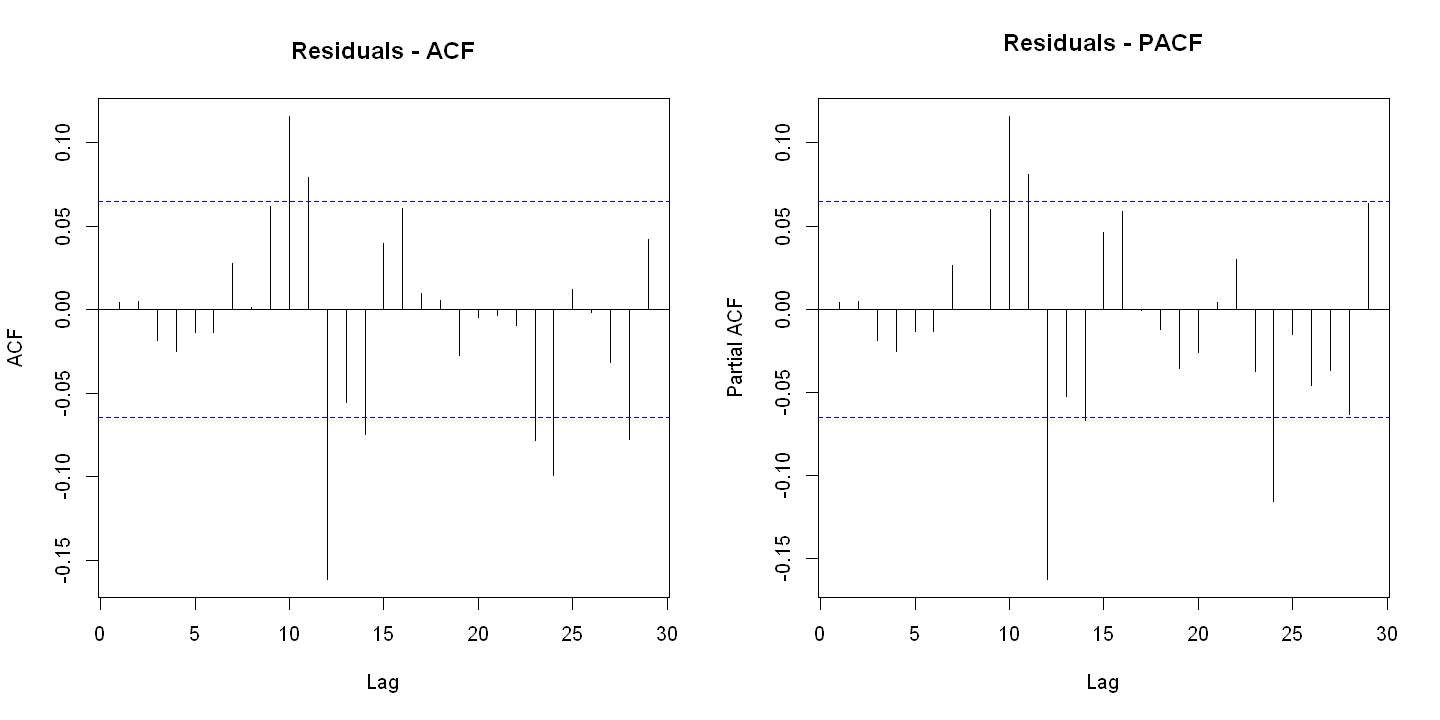

In [30]:
## CPI ARMA modelling
CPI_ARMA <- arima(cpi_pop_change, order = c(1, 0, 2))
CPI_ARMA

par(mfrow = c(1, 2))
acf(CPI_ARMA$residuals, main = 'Residuals - ACF')
pacf(CPI_ARMA$residuals, main = 'Residuals - PACF')

Box.test(CPI_ARMA$residuals, type = "Ljung-Box", lag = 4)
Box.test(CPI_ARMA$residuals, type = "Ljung-Box", lag = 8)
Box.test(CPI_ARMA$residuals, type = "Ljung-Box", lag = 12)


The residuals seem well behaved in both cases, although there is the peculiar persistence in the 12th lag in the CPI residuals, as we mentioned. We did a bit of exploration, but the seasonality trend should be gone, so we suspect this may be caused by some outliers in the series.

Now let's **run some forecasts**. This can be done using the `forecast` package.


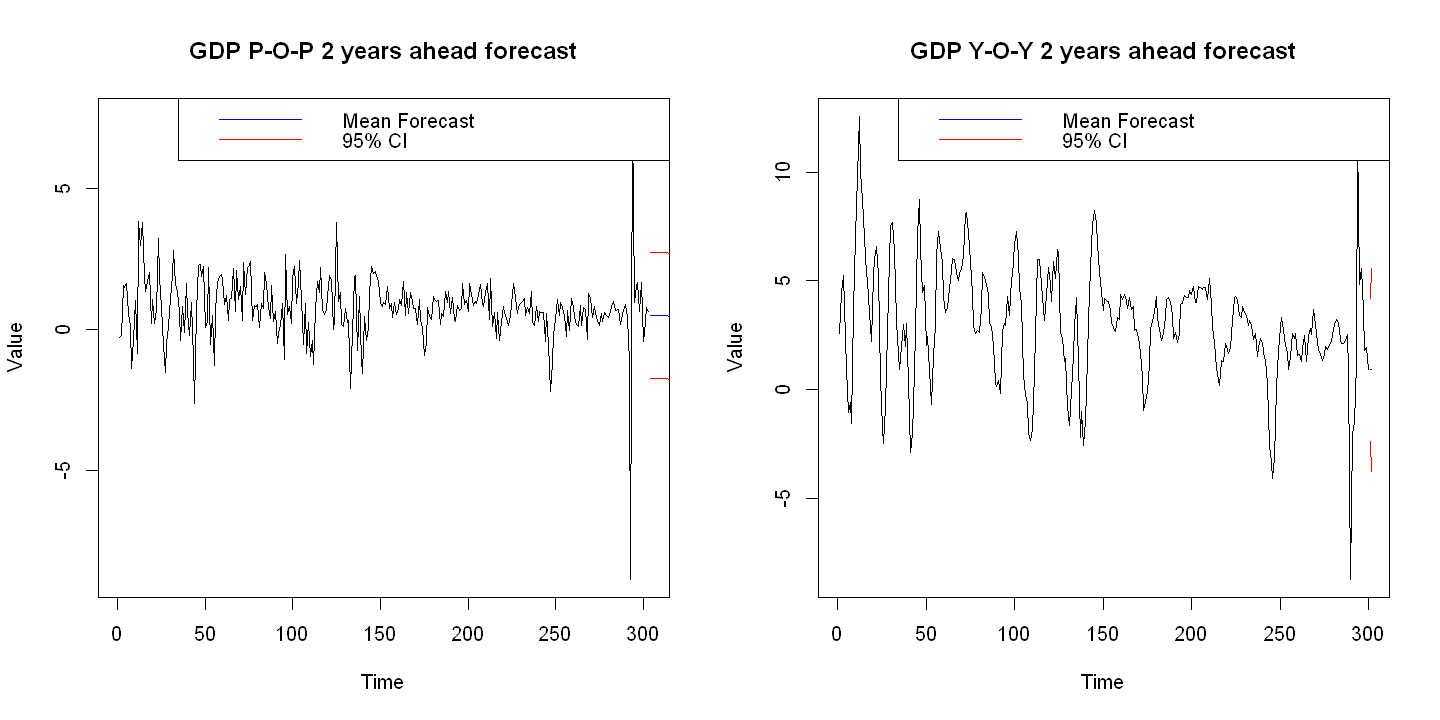

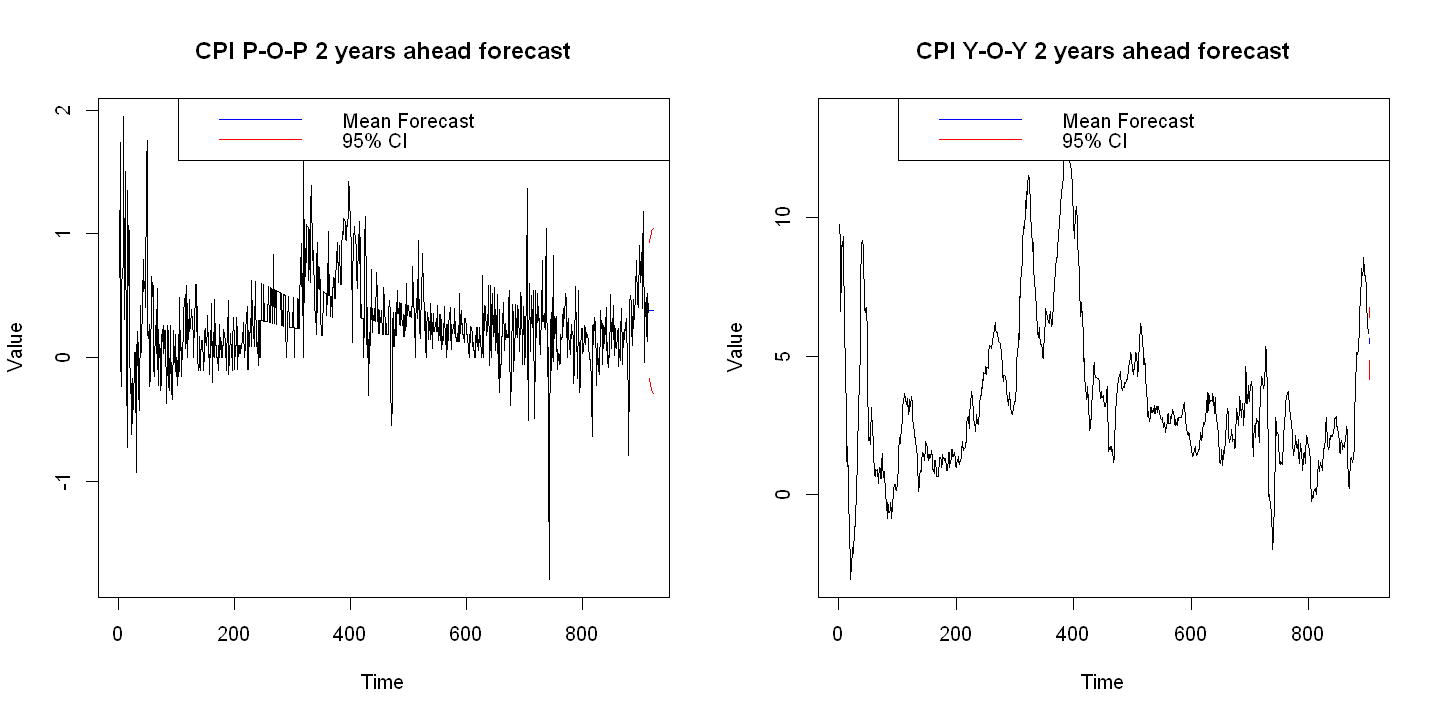

In [31]:
## Forecast 2 years ahead

# Forecast GDP
par(mfrow = c(1,2))
gdp_pop_forecast <- forecastData(gdp_pop_change, periods=24, date_frequency="month", series_name="GDP P-O-P")
gdp_yoy_forecast <- forecastData(gdp_yoy_change, periods=2, date_frequency="year", series_name="GDP Y-O-Y")

# Forecast CPI
par(mfrow = c(1,2))
cpi_pop_forecast <- forecastData(cpi_pop_change, periods=8, date_frequency="quarter", series_name="CPI P-O-P")
cpi_yoy_forecast <- forecastData(cpi_yoy_change, periods=2, date_frequency="year", series_name="CPI Y-O-Y")


Now, we are able to run 2 forecasts for each series only - first, it's monthly for CPI, and quarterly for GDP, and then we have yearly for each of these two. This should be most sufficient, and in the case of GDP, we do not have the data to do more.

As for the forecasts themselves **we choose to run a very simple form, using the `forecast` package**. A rolling or expanding forecast could also make sense, to account for the new, forecasted data, but we may consider doing that in the future.

As for the results, it seems that in the P-O-P case, the forecasts just predict a linear continuation of the series in both cases, without much change, while in the Y-O-Y case, the suggested forecasts tend toward mean reversal, although that is just us judging by a quick glance.

### *Estimating the Output Gap*:

##### Hodrick-Prescott Filter:

We will start with obtaining the Hodrick-Prescott filter, and observing its various specifications.

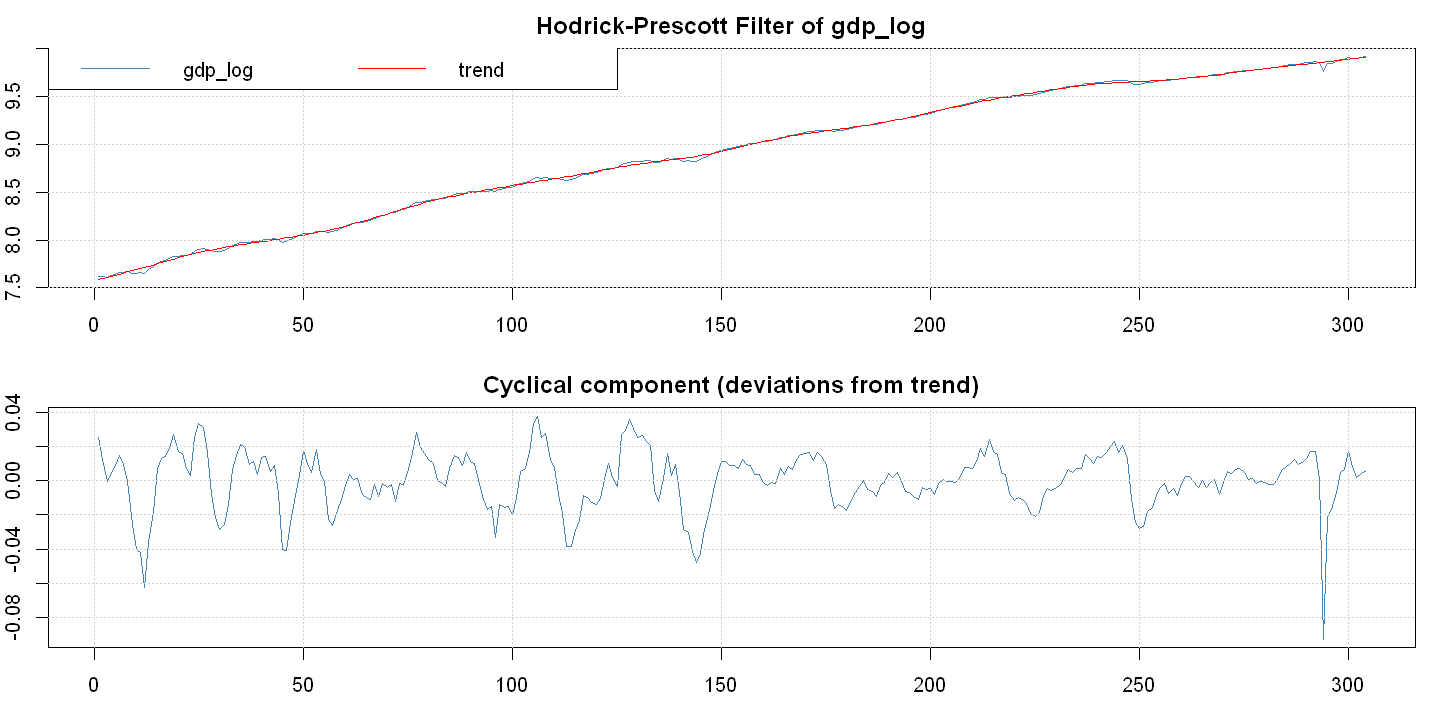

In [32]:
### 5.

# Hodrick-Prescott filter
hp <- hpfilter(gdp_log, freq=1600, type="lambda") # Source data have seasonality removed
hp_OG <- as.xts(hp$cycle, order.by=index(gdp_log)) # Output gap
plot(hp)

To run the structural checks, we will make use of the function we defined before - `runStructuralChecks`.  We take a look at the structural specifications of the output gap, and make forecasts.

[1] "Running structural checks for Q-O-Q Output Gap"
[1] "Testing for breakpoints..."


Extracting statistics...



  |======================================================================| 100%
statcheck did not find any results
[1] "Running the augmented Dickey-Fuller test for Q-O-Q Output Gap..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -6.7362, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary

[1] "The transformed series is stationary and has zero order of integration"


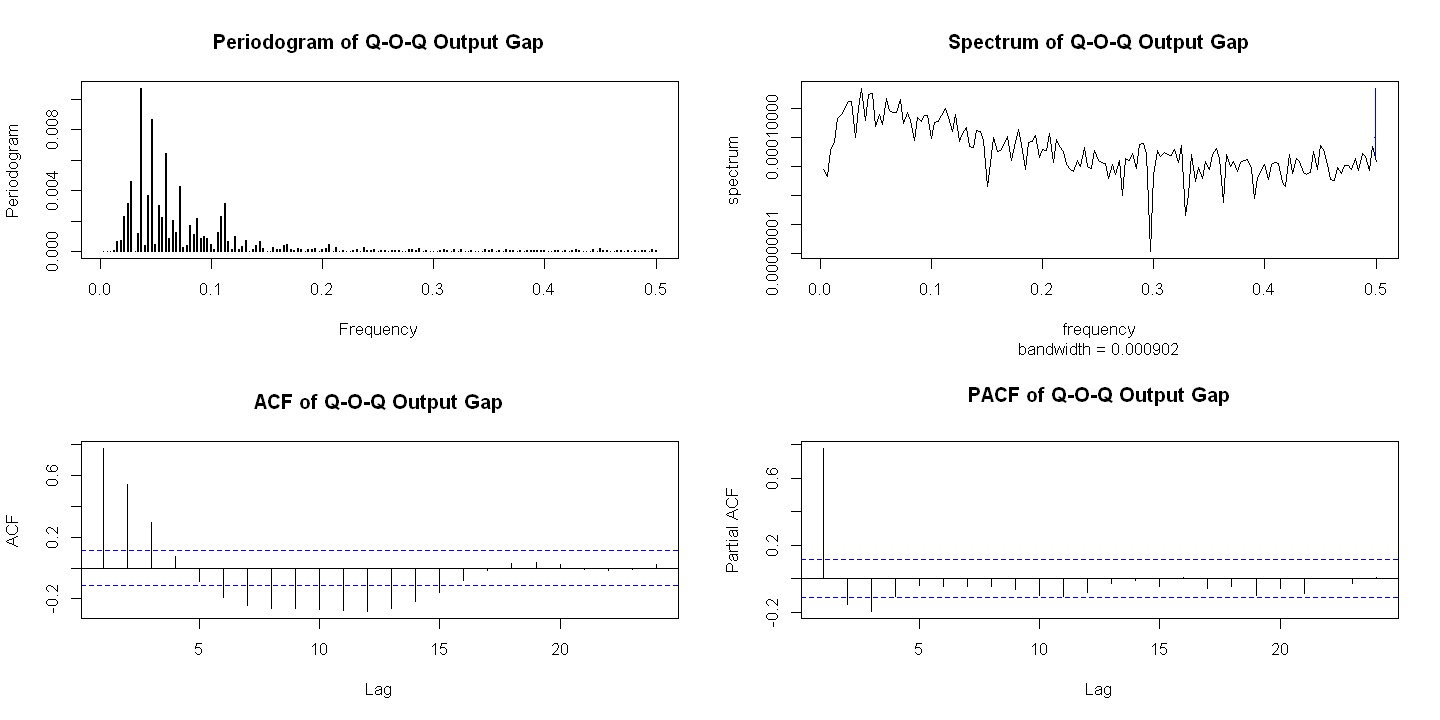

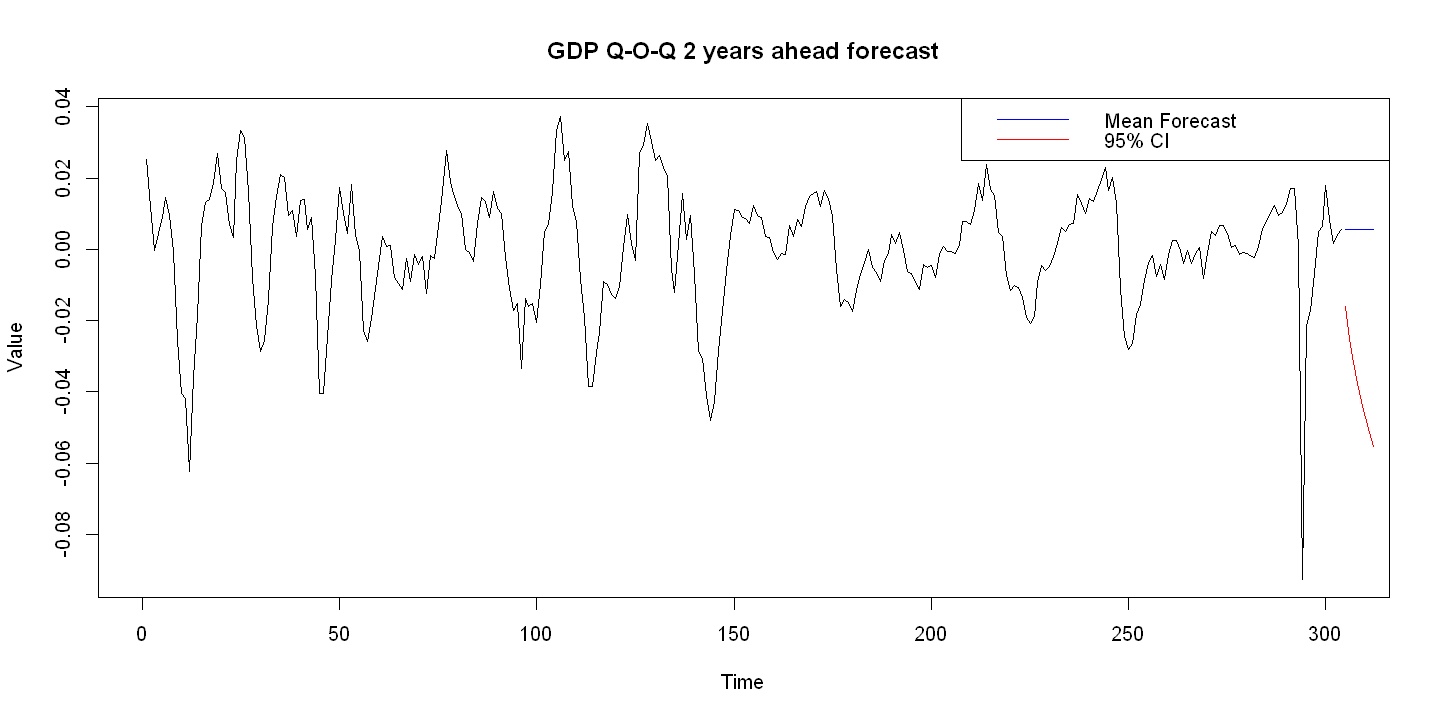

In [33]:
# Run various structural checks using a compact function (for details see the source R script)
par(mfrow=c(2,2))
runStructuralChecks(hp_OG, "Q-O-Q Output Gap")

# Forecast using the GDP trend

par(mfrow=c(1,1))
hp_forecast <- forecastData(hp_OG, periods=8, date_frequency="quarter", series_name="GDP Q-O-Q")

For the Hodrick-Prescott filter, we set the smoothing parameter to $\lambda = 1600$, as that is the best practice, as far as we remember. The series appears stationary, with no major structural breaks within.

The forecast function shows us nothing interesting at first glance, as the mean forecast remains almost unchanging, with a considerably wide confidence interval. Furthermore, given the large relative deviations of the quarter-over-quarter differences, which we use for forecasting, it may be naive to assume such small deviation for the forecast, but that is just our personal opinion.

##### Hamilton's regression filter

Next we move onto the *Hamilton's regression filter*. Building the filter is straightforward, and afterwards we use the same methodology for estimation as in the case of the H-P filter.

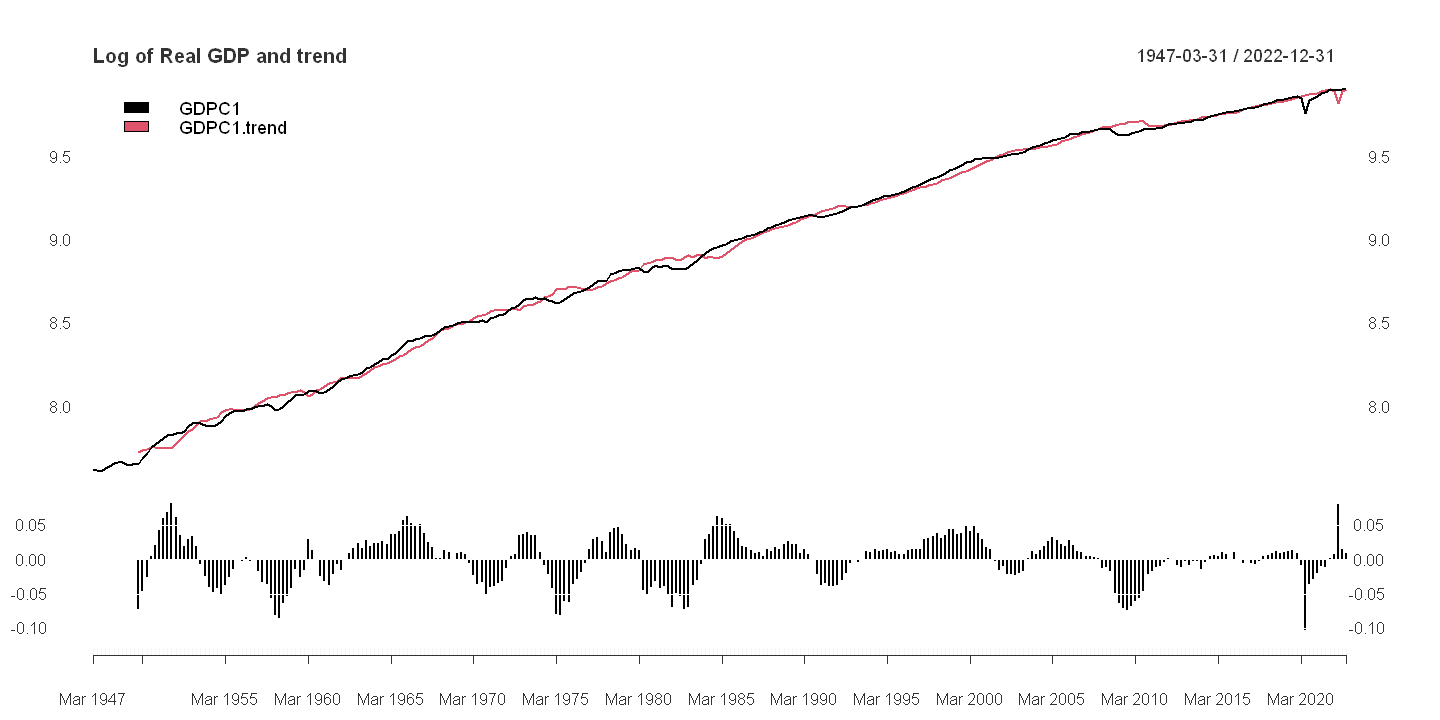

In [34]:
# Hamilton filter
gdp_HAM <- yth_filter(gdp_log, h= 8, p = 4)
ham_OG <- na.omit(gdp_HAM[,3])
par(mfrow=c(1,1))
plot(gdp_HAM[,1:2], grid.col = "white", legend.loc = "topleft", main = "Log of Real GDP and trend", panels = 'lines(gdp_HAM[,3], type="h", on=NA)')

[1] "Running structural checks for Q-O-Q GDP Output Gap"
[1] "Testing for breakpoints..."


Extracting statistics...



  |======================================================================| 100%
statcheck did not find any results
[1] "Running the augmented Dickey-Fuller test for Q-O-Q GDP Output Gap..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -4.654, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary

[1] "The transformed series is stationary and has zero order of integration"


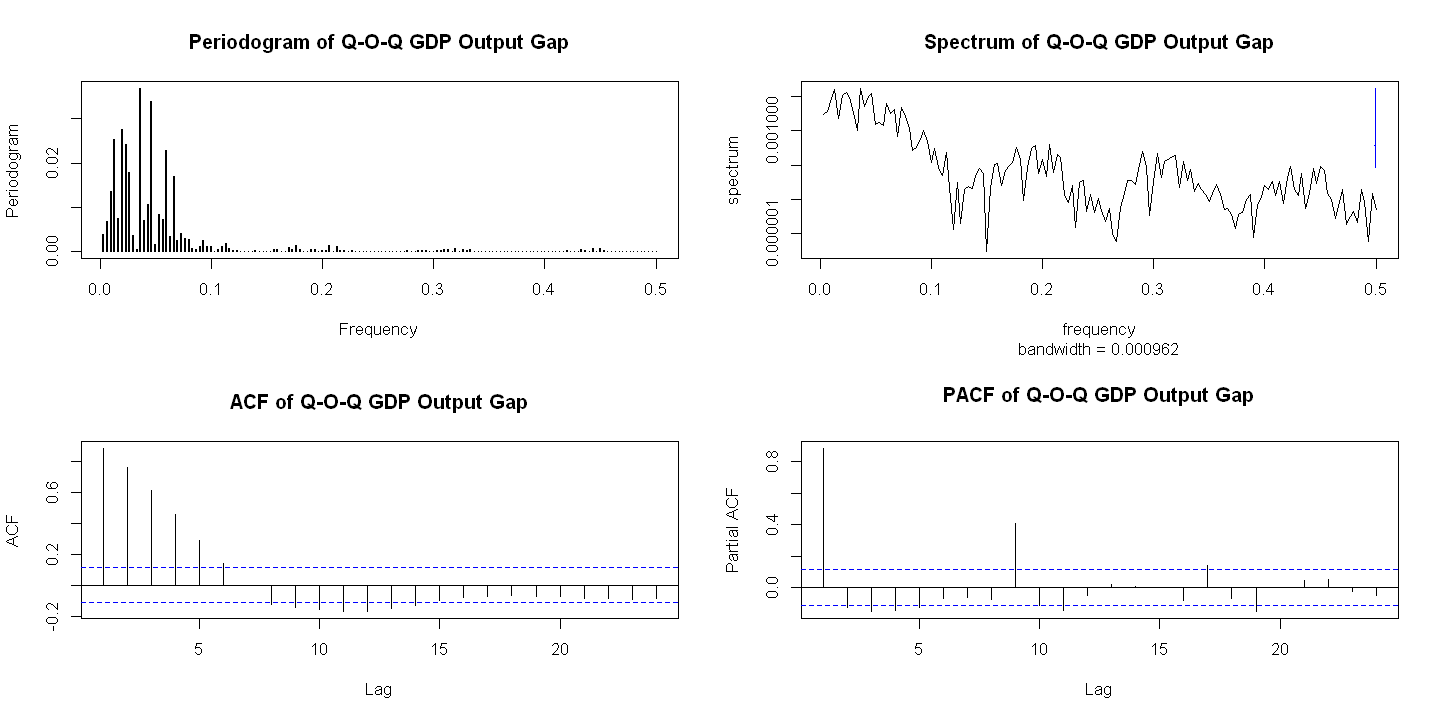

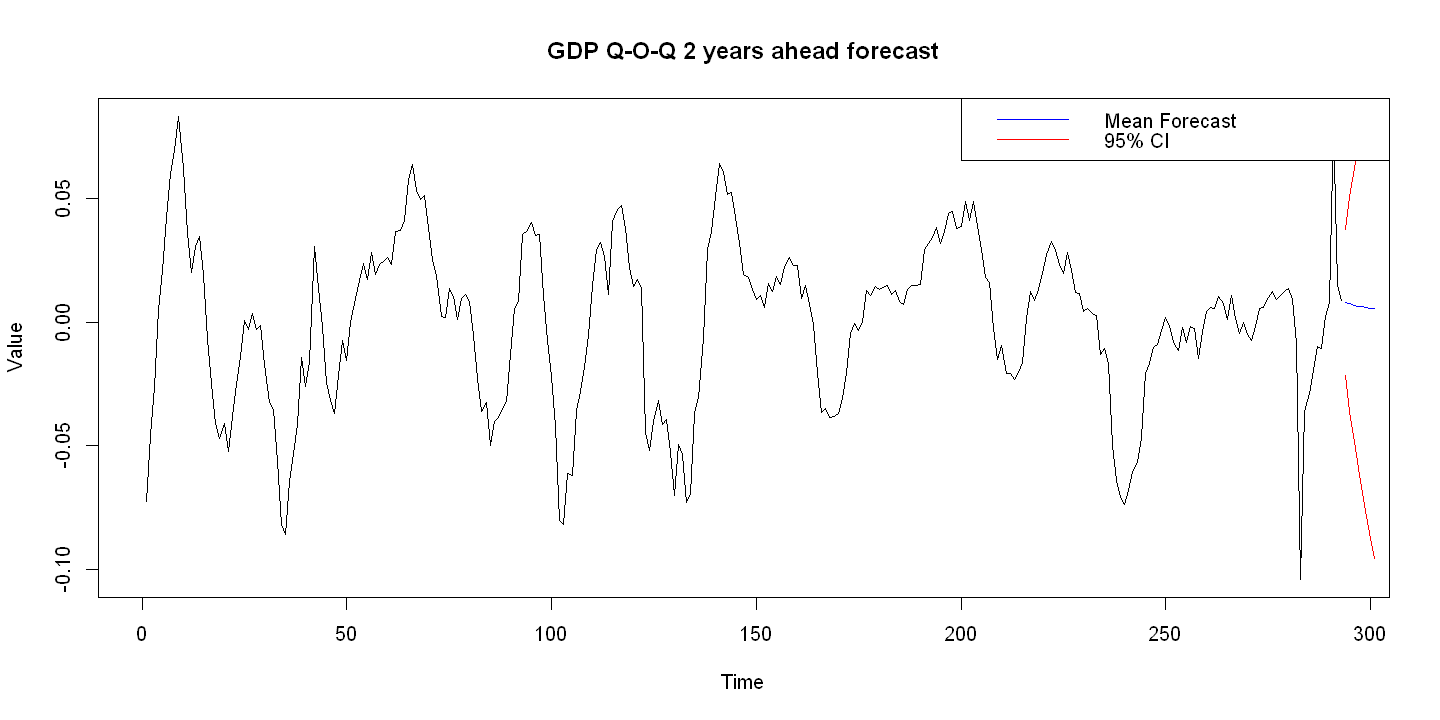

In [35]:
# Run various structural checks using a compact function (for details see the source R script)
par(mfrow=c(2,2))
runStructuralChecks(ham_OG, "Q-O-Q GDP Output Gap")

# Forecast using the GDP trend

par(mfrow=c(1,1))
ham_OG_forecast <- forecastData(ham_OG, periods=8, date_frequency="quarter", series_name="GDP Q-O-Q")

The results do not vary much, perhaps with the exception of a slightly more pessimistic forecast for the 2-years-ahead period.

Again, the series appears strongly stationary, with no apparent structural breaks.

##